# LLM - Detect AI Generated Text

The competition dataset comprises about 10,000 essays, some written by students and some generated by a variety of large language models (LLMs). The goal of the competition is to determine whether or not essay was generated by an LLM.

All of the essays were written in response to one of seven essay prompts. In each prompt, the students were instructed to read one or more source texts and then write a response. This same information may or may not have been provided as input to an LLM when generating an essay.

Essays from two of the prompts compose the training set; the remaining essays compose the hidden test set. Nearly all of the training set essays were written by students, with only a few generated essays given as examples. You may wish to generate more essays to use as training data.

Please note that this is a Code Competition. The data in test_essays.csv is only dummy data to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 9,000 essays in the test set, both student written and LLM generated.

Link: https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data?select=train_prompts.csv

# Lists of Contents
- Import Tools
- Exploratory Data Analysis
  - Data Collection
  - Understanding the Data
  - Cleaning the Data, Indentify Correlated Variables
- Data Preprocessing
- Feature Engineering
- Model Selection, Training and Validation
- Submission

# Import Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import ngrams
from collections import Counter
import nltk
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

import requests

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier


import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

nltk.download('punkt') # pre-trained unsupervised machine learning model for sentence tokenization
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') # pre-trained model used for POS

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Exploratory Data Analysis

## Data collection
Since there are only a few data provided from the dataset, we'll find the data from other sources for more efficiency.

Data sources: https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/452085

In [2]:
!kaggle competitions download -c llm-detect-ai-generated-text
!kaggle datasets download -d thedrcat/daigt-proper-train-dataset
!kaggle datasets download -d radek1/llm-generated-essays
!kaggle datasets download -d alejopaullier/daigt-external-dataset

In [3]:
!tar -xf llm-detect-ai-generated-text.zip
!tar -xf daigt-external-dataset.zip
!tar -xf daigt-proper-train-dataset.zip
!tar -xf llm-generated-essays.zip

In [4]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is E2E8-DD6A

 Directory of C:\Users\USER\Downloads\ml-journey\Datasets\NLP\LLM - Detect AI Generated Text

01/05/2024  10:47 AM    <DIR>          .
01/05/2024  10:47 AM    <DIR>          ..
12/30/2023  11:39 AM    <DIR>          .ipynb_checkpoints
11/02/2023  11:27 PM         1,797,451 ai_generated_train_essays.csv
11/02/2023  11:27 PM           610,035 ai_generated_train_essays_gpt-4.csv
01/05/2024  09:05 AM    <DIR>          catboost_info
10/31/2023  07:11 PM         3,006,707 daigt-external-dataset.zip
11/05/2023  02:04 PM       124,388,618 daigt-proper-train-dataset.zip
10/31/2023  07:11 PM         9,466,916 daigt_external_dataset.csv
03/04/2020  01:43 PM       347,116,733 glove.6B.100d.txt
01/05/2024  10:26 AM       347,117,172 glove.6B.100d.txt.word2vec
03/04/2020  01:44 PM       137,847,651 glove6b100dtxt.zip
10/26/2023  04:54 PM         1,449,919 llm-detect-ai-generated-text.zip
11/02/2023  11:27 PM           533,115 llm-gene

## Understanding the Data

In [5]:
# Our competition data
train_essays_df = pd.read_csv("train_essays.csv")
test_essays_df = pd.read_csv("test_essays.csv")

# External data
df1 = pd.read_csv("ai_generated_train_essays.csv")
df2 = pd.read_csv("ai_generated_train_essays_gpt-4.csv")
df3 = pd.read_csv("daigt_external_dataset.csv")
df4 = pd.read_csv("train_drcat_01.csv")
df5 = pd.read_csv("train_drcat_02.csv")
df6 = pd.read_csv("train_drcat_03.csv")
df7 = pd.read_csv("train_drcat_04.csv")

print(f"Competition train data: {train_essays_df.shape}, test data:{test_essays_df.shape}")

Competition train data: (1378, 4), test data:(3, 3)


In [6]:
train_essays_df = train_essays_df[["text", "generated"]]
df1 = df1[["text", "generated"]]
df2 = df2[["text", "generated"]]
df3 = df3[["source_text"]].rename(columns={"source_text": "text"})
df3["generated"] = 1
df4 = df4[["text", "label"]].rename(columns={"label": "generated"})
df5 = df5[["text", "label"]].rename(columns={"label": "generated"})
df6 = df6[["text", "label"]].rename(columns={"label": "generated"})
df7 = df7[["text", "label"]].rename(columns={"label": "generated"})

dfs = [train_essays_df, df1, df2, df3, df4, df5, df6, df7]
for _index, _value in enumerate(dfs):
    print(f"df{_index} has : {_value.shape}")

df0 has : (1378, 2)
df1 has : (500, 2)
df2 has : (200, 2)
df3 has : (2421, 2)
df4 has : (33259, 2)
df5 has : (39785, 2)
df6 has : (42206, 2)
df7 has : (44206, 2)


Combine them all

In [7]:
combined_df = pd.concat([i for i in dfs], axis=0)
human_df= combined_df[combined_df.generated == 0]
ai_df = combined_df[combined_df.generated == 1]
combined_df.shape

(163955, 2)

### Basic informations

In [8]:
combined_df.sample(5)

,text,generated
28239,"DEAR Principal ,\n\nI think that policy 1 that...",0
7454,Many societies around the world unfortunately ...,1
4899,"it was 1995, world war ll was over in europe, ...",0
26376,Protect us From Ourselves\n\nHumans have a str...,0
26450,"In my opinion, the idea to take off one day of...",0


In [9]:
combined_df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [10]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 163955 entries, 0 to 44205
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       163955 non-null  object
 1   generated  163955 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ MB


In [11]:
combined_df.describe()

,generated
count,163955.000000
mean,0.287933
std,0.452801
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [12]:
combined_df.isnull().sum()

text         0
generated    0
dtype: int64

### Analyze data distributions

In [13]:
combined_df["generated"].value_counts()

generated
0    116747
1     47208
Name: count, dtype: int64

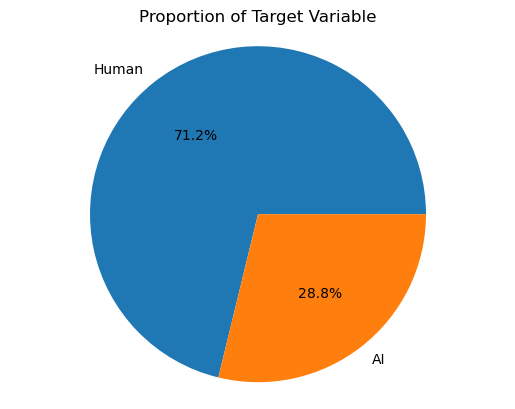

In [14]:
plt.pie(combined_df["generated"].value_counts(), labels=['Human', 'AI'], autopct='%1.1f%%')
plt.title('Proportion of Target Variable')
plt.axis('equal')
plt.show()

### Analyze length of texts distributions

In [15]:
grouped_data = combined_df.copy()
grouped_data["avg_length"] = grouped_data["text"].apply(len)
grouped_data = grouped_data.groupby("generated")["avg_length"].mean().reset_index()
grouped_data

,generated,avg_length
0,0,2346.391813
1,1,1906.227525


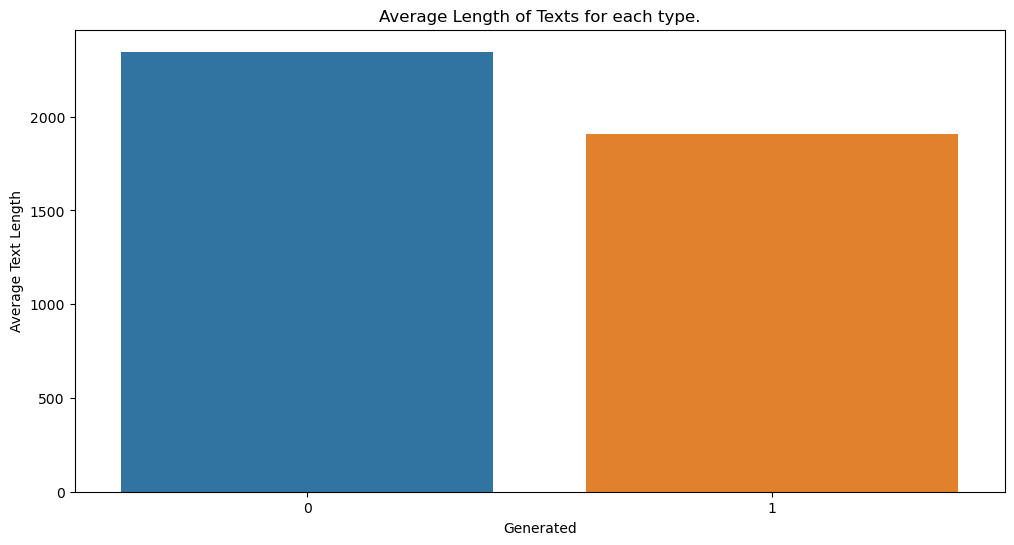

In [16]:
plt.figure(figsize=(12, 6))
sns.barplot(x="generated", y="avg_length", data=grouped_data)
plt.title('Average Length of Texts for each type.')
plt.xlabel('Generated')
plt.ylabel('Average Text Length')
plt.show()

### Word Frequency Analysis

In [ ]:
# # Tokenize each row into a format like [Cars, ., Cars, have, been, around, since, the...
# human_words = human_df['text'].apply(word_tokenize)
# ai_words = ai_df['text'].apply(word_tokenize)

# # Use python Counter to count each word
# human_word_counts = Counter(word for sublist in human_words for word in sublist)
# ai_word_counts = Counter(word for sublist in ai_words for word in sublist)
# # Get 20 most common word
# print(f"20 most common human words: {human_word_counts.most_common(20)}\n")
# print(f"20 most common ai words: {ai_word_counts.most_common(20)}")


### N-gram Analysis

In [ ]:
# def extract_ngrams(data, n):
#     """Find the most n-consecutive that occurs in the data."""
#     n_grams = ngrams(word_tokenize(data), n)
#     return [' '.join(grams) for grams in n_grams]

# # Look for any 2 consecutive words
# human_bigrams = human_df['text'].apply(lambda x: extract_ngrams(x, 2))
# ai_bigrams = ai_df['text'].apply(lambda x: extract_ngrams(x, 2))

# human_bigram_counts = Counter(bigram for sublist in human_bigrams for bigram in sublist)
# ai_bigram_counts = Counter(bigram for sublist in ai_bigrams for bigram in sublist)

# print(f"20 most common human bigram: {human_bigram_counts.most_common(20)}\n")
# print(f"20 most common ai bigram: {ai_bigram_counts.most_common(20)}\n")

## Cleaning the Data, Indentify Correlated Variables

Since our df has no missing values and we're only using 2 columns which are text and generated we'll skipping this step.

# Data Preprocessing

The goal is to prepare the data in a way that maximizes the model's ability to learn distinguishing features while preserving the characteristics that differentiate human and AI writing styles. 

## Text Cleaning

Remove noise and standardize the text without eliminating features that might be crucial for distinguishing between human and AI writing.

In [19]:
combined_df.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [20]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub('[^\w\s]', '', text) # Keep only word char and white space
    text = text.lower()
    return text

cleaned_df = combined_df.copy()
cleaned_df["cleaned_text"] = cleaned_df["text"].apply(clean_text)
cleaned_df.head()

,text,generated,cleaned_text
0,Cars. Cars have been around since they became ...,0,cars cars have been around since they became f...
1,Transportation is a large necessity in most co...,0,transportation is a large necessity in most co...
2,"""America's love affair with it's vehicles seem...",0,americas love affair with its vehicles seems t...
3,How often do you ride in a car? Do you drive a...,0,how often do you ride in a car do you drive a ...
4,Cars are a wonderful thing. They are perhaps o...,0,cars are a wonderful thing they are perhaps on...


## Tokenization

Remove noise and standardize the text without eliminating features that might be crucial for distinguishing between human and AI writing.

In [21]:
cleaned_df["tokens"] = cleaned_df["cleaned_text"].apply(word_tokenize)
cleaned_df.head()

,text,generated,cleaned_text,tokens
0,Cars. Cars have been around since they became ...,0,cars cars have been around since they became f...,"[cars, cars, have, been, around, since, they, ..."
1,Transportation is a large necessity in most co...,0,transportation is a large necessity in most co...,"[transportation, is, a, large, necessity, in, ..."
2,"""America's love affair with it's vehicles seem...",0,americas love affair with its vehicles seems t...,"[americas, love, affair, with, its, vehicles, ..."
3,How often do you ride in a car? Do you drive a...,0,how often do you ride in a car do you drive a ...,"[how, often, do, you, ride, in, a, car, do, yo..."
4,Cars are a wonderful thing. They are perhaps o...,0,cars are a wonderful thing they are perhaps on...,"[cars, are, a, wonderful, thing, they, are, pe..."


## Stop Words Removal

Remove common words that might not contribute to our prediction.

In [22]:
stop_words = stopwords.words("english")
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [23]:
# Remove stopwords in our data
cleaned_df["tokens"] = cleaned_df["tokens"].apply(lambda x: [word for word in x if word not in stop_words])
cleaned_df.head()

,text,generated,cleaned_text,tokens
0,Cars. Cars have been around since they became ...,0,cars cars have been around since they became f...,"[cars, cars, around, since, became, famous, he..."
1,Transportation is a large necessity in most co...,0,transportation is a large necessity in most co...,"[transportation, large, necessity, countries, ..."
2,"""America's love affair with it's vehicles seem...",0,americas love affair with its vehicles seems t...,"[americas, love, affair, vehicles, seems, cool..."
3,How often do you ride in a car? Do you drive a...,0,how often do you ride in a car do you drive a ...,"[often, ride, car, drive, one, motor, vehicle,..."
4,Cars are a wonderful thing. They are perhaps o...,0,cars are a wonderful thing they are perhaps on...,"[cars, wonderful, thing, perhaps, one, worlds,..."


## Lemmatization (Can Skip)

Reduce words to their base or root form. (countries -> country)

In [24]:
# lemmatizer =  WordNetLemmatizer()
# cleaned_df["lemmatized"] = cleaned_df["tokens"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# cleaned_df.head()

In [25]:
# print(lemmatizer.lemmatize("countries"))
# print(lemmatizer.lemmatize("doing"))
# print(lemmatizer.lemmatize("done"))
# print(lemmatizer.lemmatize("do"))
# print(lemmatizer.lemmatize("did"))

# Feature Engineering

## Feature Extraction

Transform text data into a format that machine learning algorithms can understand. (Text data -> numerical features)

We have 3 simple choices here which are:

- **TF-IDF:** Focus on frequency of word
- **N-Grams:** Focus on order of word
- **POS (Part-of-Speech):** Focus on grammatical properties. Assigns a grammatical category.
- **glove2word2vec:** Word embedding. (Focus on the semantic relationships between words).

In this case, I'll choose TF-IDF and POS

`TfidfVectorizer` already performs its own tokenization and we want to minimize preprocessing to preserve the original text structure and style. So, we can consider using only the `cleaned_df["cleaned_text"]` for TfidfVectorizer and skip want we've done so far.

In [26]:
cleaned_df.sample(5)

,text,generated,cleaned_text,tokens
32400,Dear TEACHER_NAME I agree with you're choice t...,0,dear teacher_name i agree with youre choice to...,"[dear, teacher_name, agree, youre, choice, all..."
5409,I think that meditation and mindfulness practi...,1,i think that meditation and mindfulness practi...,"[think, meditation, mindfulness, practices, su..."
21897,We should not keep the Electoral college becau...,0,we should not keep the electoral college becau...,"[keep, electoral, college, first, unfair, also..."
4991,ELECTORAL COLLEGE\n\nI strongly believe that t...,0,electoral college\n\ni strongly believe that t...,"[electoral, college, strongly, believe, electo..."
29961,Dear TEACHER\_NAME;\n\nWhat happens when ther...,1,dear teacher_name\n\nwhat happens when theres...,"[dear, teacher_name, happens, theres, event, c..."


### TF-IDF Features

Parameters Explanation
- **max_df**: This parameter is used to remove terms that appear too frequently (less informative). 0.95 means that terms that appear more than 95% will be ignore
- **ngram_range**: Decides the range of n-grams to be considered (min_n, max_n).
- **norm**: Normalize, Common value is 'l2', which ensures all feature vectors have a Euclidean norm of 1

In [27]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=1, ngram_range=(1, 2), norm='l2')  # we can also add the stop_words='english' param.
matrix = vectorizer.fit_transform(cleaned_df["cleaned_text"])
matrix

<163955x1552634 sparse matrix of type '<class 'numpy.float64'>'
	with 76609501 stored elements in Compressed Sparse Row format>

### POS Tag Features

Part-of-Speech tagging involves assigning word classes (like nouns, verbs, adjectives) to each word in a sentence. This can provide valuable syntactic information that might help differentiate AI-generated text from human-generated text.

In [28]:
# def pos_tag_features(df):
#     """Collects POS for each word."""
#     pos_tags = []
#     for row in df.loc[:, "tokens"]:
#         pos_tags.append([tag for _, tag in nltk.pos_tag(row)])
#     return pos_tags

# pos_features = pos_tag_features(cleaned_df)

In [29]:
# for row in cleaned_df.loc[:, "tokens"]:
#     print(nltk.pos_tag(row))
#     break

In [30]:
# mlb = MultiLabelBinarizer() # POS tags into binary features
# pos_binary_features = mlb.fit_transform(pos_features)

### Word Embeddings

Capture semantic relationships between words based on their context in large corpora. They can encode nuanced semantic similarities and differences.

Semantically similar words are mapped to nearby points based on their usage in the language. 

In [31]:
# !kaggle datasets download -d sawarn69/glove6b100dtxt

In [32]:
# !tar -xf glove6b100dtxt.zip

What we're doing here is
- Converting GloVe to Word2Vec Format: Both GloVe and Word2Vec are a type of word embedding that provides vector representations of words based on their co-occurrence information. The KeyedVectors expected Word2Vec format so we converted the GloVe to Word2Vec

- Loads the converted Word2Vec format file into a model using Gensim’s `KeyedVectors`
- The `document_vector` function aims to create a single vector representation for a whole document (text) by averaging the vectors of the words contained in the document.
  - For each word in the document, if the word is in the Word2Vec model, its vector is retrieved. Then, it calculates the mean of these vectors. If the document contains no words found in the model, a zero vector of the appropriate size is returned.
  - By averaging the word vectors, you effectively blend the semantic content of all the words in the document. This results in a single vector that captures the central semantic theme of the entire text.

In [33]:
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

word2vec_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

def document_vector(model, words):
    """Create a single vector representation for a whole document."""
    word_vectors = [model[word] for word in words if word in model]
    return np.mean(word_vectors, axis=0) if len(word_vectors) > 0 else np.zeros(model.vector_size)

embeddings = np.array([document_vector(word2vec_model, words) for words in cleaned_df["tokens"]])

C:\Users\USER\AppData\Local\Temp\ipykernel_17356\593839627.py:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [34]:
word2vec_model

In [35]:
embeddings

array([[-0.03574403,  0.08971498,  0.25011492, ..., -0.05944224,
         0.5707558 ,  0.05101369],
       [-0.12007192,  0.1136037 ,  0.19056433, ..., -0.0987911 ,
         0.54893464, -0.01622855],
       [-0.12632363,  0.17422739,  0.2733032 , ..., -0.2774453 ,
         0.4963882 ,  0.07030004],
       ...,
       [-0.15380426,  0.21120003,  0.34175447, ..., -0.4028472 ,
         0.31330302,  0.0422128 ],
       [-0.09494431,  0.1016719 ,  0.3314944 , ..., -0.17171445,
         0.4431492 ,  0.13854283],
       [ 0.06276114,  0.39203638,  0.37627307, ..., -0.1952806 ,
         0.35131416,  0.10052266]], dtype=float32)

## Combining TF-IDF, POS, and glove2word2vec

### Why combining?

- TF-IDF: Captures information about word frequencies
- POS tags: Captures syntactic information about how words function in sentences.
- glove2word2vec: Captures a semantic and relationships between words

Combining all of these makes we can deeply capture the difference between human and AI writing. But note that it can lead to a high-dimensional feature space.

### Reduce the TF-IDF's dimentaion before combine

Find the optimal n_components

In [36]:
matrix_svd = TruncatedSVD(n_components=100).fit(matrix)
matrix_cumulative_explained_variance = np.cumsum(matrix_svd.explained_variance_ratio_)
matrix_cumulative_explained_variance

array([0.00363068, 0.01795814, 0.02780437, 0.03589831, 0.04376917,
       0.04972595, 0.05554174, 0.06081171, 0.06577973, 0.07007032,
       0.07405067, 0.07772594, 0.08122689, 0.08461294, 0.08775289,
       0.09050027, 0.09288243, 0.09520187, 0.09721338, 0.09914517,
       0.10099802, 0.10278736, 0.10453602, 0.10616103, 0.10773096,
       0.10924868, 0.1107208 , 0.11208402, 0.11338043, 0.1146168 ,
       0.11581884, 0.11693532, 0.11803525, 0.11908935, 0.12012741,
       0.12113437, 0.12211464, 0.1230682 , 0.12401722, 0.12494202,
       0.12585282, 0.12674489, 0.12763008, 0.12849373, 0.12933713,
       0.13014317, 0.13093196, 0.13170914, 0.13245846, 0.13319829,
       0.13393379, 0.13465715, 0.13537872, 0.13608967, 0.13678468,
       0.13747349, 0.13815342, 0.1388234 , 0.1394873 , 0.14014393,
       0.14079196, 0.14143501, 0.14207254, 0.14270785, 0.1433304 ,
       0.14394561, 0.14455435, 0.14515662, 0.1457555 , 0.14635012,
       0.14694143, 0.14752571, 0.14810502, 0.14867808, 0.14924

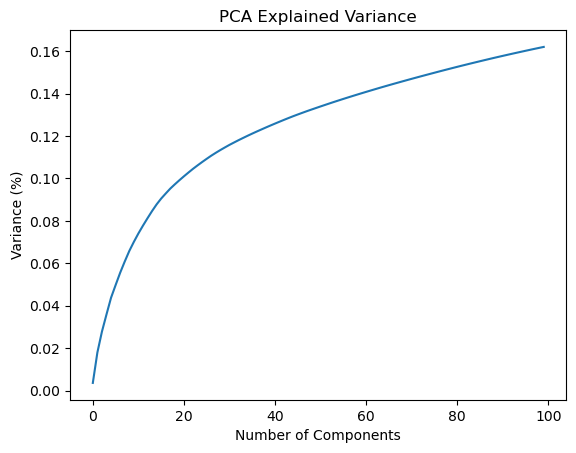

In [37]:
plt.figure()
plt.plot(matrix_cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('PCA Explained Variance')
plt.show()

In [38]:
desired_variance = 0.95
optimal_matrix_components = np.argmax(matrix_cumulative_explained_variance >= desired_variance, axis=0) + 1 # Find the first index that >= 95% variance
optimal_matrix_components

1

In [39]:
matrix_svd = TruncatedSVD(n_components=optimal_matrix_components)
reduced_matrix = matrix_svd.fit_transform(matrix)
reduced_matrix

array([[0.20207894],
       [0.14065222],
       [0.21298314],
       ...,
       [0.11842354],
       [0.21836053],
       [0.24123475]])

### Reduce the POS's dimentaion before combine

Find the optimal n_components

In [40]:
# pos_svd = TruncatedSVD(n_components=37).fit(pos_binary_features)
# pos_cumulative_explained_variance = np.cumsum(pos_svd.explained_variance_ratio_)
# pos_cumulative_explained_variance

In [41]:
# plt.figure()
# plt.plot(pos_cumulative_explained_variance)
# plt.xlabel('Number of Components')
# plt.ylabel('Variance (%)')  # for each component
# plt.title('PCA Explained Variance')
# plt.show()

In [42]:
# desired_variance = 0.95
# optimal_pos_components = np.argmax(pos_cumulative_explained_variance >= desired_variance, axis=0) + 1 # Find the first index that >= 95% variance
# optimal_pos_components

In [43]:
# pos_svd = TruncatedSVD(n_components=optimal_pos_components)
# reduced_pos = pos_svd.fit_transform(pos_binary_features)
# reduced_pos

### Reduce the Word Embedding's dimentaion before combine

Find the optimal n_components

In [44]:
pca = PCA().fit(embeddings) # Full components
pca_cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
pca_cumulative_explained_variance

array([0.18233893, 0.34165949, 0.46660898, 0.56256244, 0.62436358,
       0.6664137 , 0.69882897, 0.72183939, 0.74140235, 0.75993075,
       0.77465309, 0.7881103 , 0.80008411, 0.81060891, 0.82066517,
       0.83028742, 0.8385109 , 0.84628303, 0.85342057, 0.85986631,
       0.86600867, 0.87209014, 0.87758767, 0.88249225, 0.88707485,
       0.89144602, 0.89561234, 0.89964607, 0.90352891, 0.90714111,
       0.91063046, 0.91392634, 0.91714799, 0.92019142, 0.92314343,
       0.92587184, 0.92854109, 0.9311213 , 0.93364723, 0.93611902,
       0.93848328, 0.94071833, 0.94282238, 0.94485198, 0.94685056,
       0.94879785, 0.95066842, 0.95247131, 0.95425057, 0.95594208,
       0.95760216, 0.95924234, 0.96081789, 0.96234535, 0.96386426,
       0.96534867, 0.96676841, 0.96812257, 0.96943079, 0.97073101,
       0.97196772, 0.97317876, 0.97438562, 0.97555905, 0.97671708,
       0.97782712, 0.9789247 , 0.97997545, 0.98100086, 0.98198725,
       0.98296252, 0.98391022, 0.98482582, 0.98572867, 0.98660

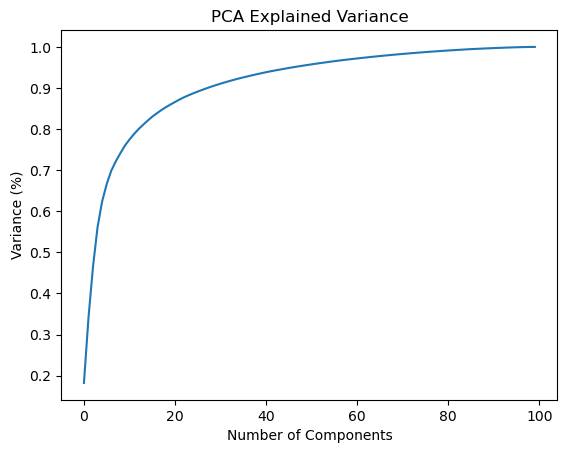

In [45]:
plt.figure()
plt.plot(pca_cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('PCA Explained Variance')
plt.show()

In [46]:
desired_variance = 0.95
optimal_pca_components = np.argmax(pca_cumulative_explained_variance >= desired_variance, axis=0) + 1 # Find the first index that >= 95% variance
optimal_pca_components

47

In [47]:
pca = PCA(n_components=optimal_pca_components)
reduced_embeddings = pca.fit_transform(embeddings)
reduced_embeddings

array([[ 0.64694417,  0.21837349, -0.20276122, ..., -0.01026708,
        -0.02893747,  0.01970111],
       [ 0.6777785 ,  0.4301534 , -0.16876376, ..., -0.04625277,
        -0.01162924,  0.00110477],
       [ 0.463873  ,  0.4343279 , -0.16477762, ...,  0.02205657,
        -0.02042884,  0.02493609],
       ...,
       [ 0.91456777,  0.42571664,  0.0312239 , ...,  0.03835852,
        -0.01895821, -0.02162884],
       [ 0.47854137, -0.29022694, -0.129156  , ...,  0.02197697,
        -0.04535942, -0.02906511],
       [-0.19205481, -0.3495213 , -0.0913974 , ...,  0.02333209,
        -0.06060707,  0.10652518]], dtype=float32)

In [48]:
combined_features = hstack([matrix, reduced_embeddings]) # pos_binary_features
combined_features

<163955x1552681 sparse matrix of type '<class 'numpy.float64'>'
	with 84315386 stored elements in COOrdinate format>

Due to the resource limitation. I'll choose only the TF-IDF.

## Dimensionality Reduction (Can skip)

### Find the the optimal n_components

In [49]:
# combined_features_csr = csr_matrix(combined_features)

# # Initialize SVD with a high number of components
# svd = TruncatedSVD(n_components=100)
# svd.fit(combined_features_csr)


In [50]:
# cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(cumulative_explained_variance, marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance vs. Number of Components')
# plt.grid()

# # Show the plot
# plt.show()


In [51]:
# desired_variance = 0.95  # For example, 95%
# optimal_components = np.argmax(cumulative_explained_variance >= desired_variance) + 1
# optimal_components

In [52]:
# svd_optimal = TruncatedSVD(n_omponents=optimal_components)
# svd_optimal.fit(combined_features_csr)

I've tried many ways but the best result is 1 which means if we try to use 2+ n_components we might lose the information so I won't reduce it.

## Data Splitting

In [53]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, cleaned_df["generated"], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((131164, 1552681), (32791, 1552681), (131164,), (32791,))

In case you reduce the dimension.

In [54]:
# X_train = svd_optimal.transform(X_train)
# X_test = svd_optimal.transform(X_test)

# Model Selection

## Simple Linear Classifier

In [55]:
# logistic_model = LogisticRegression()  
# logistic_model.fit(X_train, y_train)
# logistic_pred_proba = logistic_model.predict_proba(X_test)[:, 1]


C:\Users\USER\anaconda3\envs\JTorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
# logistic_acc = accuracy_score(y_test, logistic_model.predict(X_test))
# print("Accuracy for Logistic Regression:", logistic_acc)

# roc_auc_logistic = roc_auc_score(y_test, logistic_pred_proba)
# print("ROC AUC for Logistic Regression:", roc_auc_logistic)

Accuracy for Logistic Regression: 0.9958220243359458
ROC AUC for Logistic Regression: 0.9994623783121392


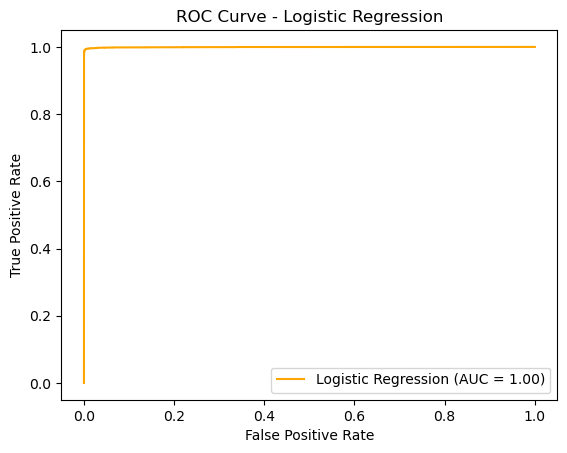

In [57]:
# fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_pred_proba)
# plt.figure()
# plt.plot(fpr_logistic, tpr_logistic, color='orange', label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Logistic Regression')
# plt.legend(loc='lower right')
# plt.show()

## Decision Tree Classifier

In [58]:
# dec_tree_model = DecisionTreeClassifier(random_state=42)
# dec_tree_model.fit(X_train, y_train)
# dec_tree_pred_proba = dec_tree_model.predict_proba(X_test)[:, 1]

In [59]:
# roc_auc_dec_tree = roc_auc_score(y_test, dec_tree_pred_proba)
# print("ROC AUC for Decision Tree:", roc_auc_dec_tree)

ROC AUC for Decision Tree: 0.9965344725411395


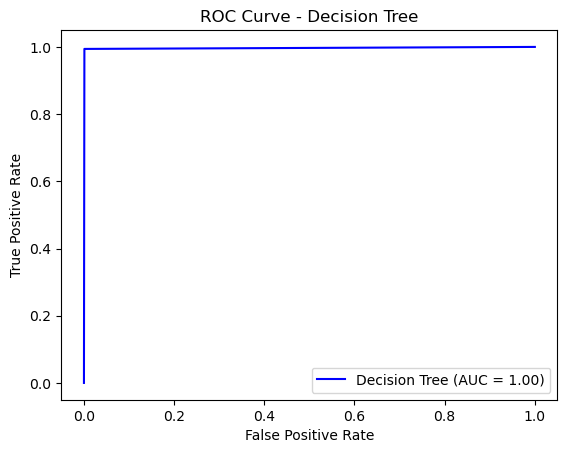

In [60]:
# fpr_dec_tree, tpr_dec_tree, _ = roc_curve(y_test, dec_tree_pred_proba)
# plt.figure()
# plt.plot(fpr_dec_tree, tpr_dec_tree, color='blue', label=f'Decision Tree (AUC = {roc_auc_dec_tree:.2f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Decision Tree')
# plt.legend(loc='lower right')
# plt.show()

## XGBoost

In [61]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [62]:
roc_auc_xgb = roc_auc_score(y_test, xgb_pred_proba)
print("ROC AUC for XGBoost:", roc_auc_xgb)

ROC AUC for XGBoost: 0.9999891442102194


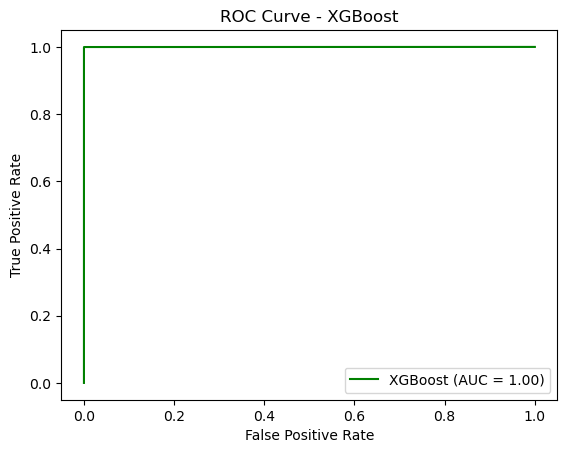

In [63]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='green', label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()

## LightGBM

In [64]:
# lgb_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')
# lgb_model.fit(X_train, y_train)
# lgb_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 37791, number of negative: 93373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 66.767563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7492524
[LightGBM] [Info] Number of data points in the train set: 131164, number of used features: 196759
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288120 -> initscore=-0.904531
[LightGBM] [Info] Start training from score -0.904531


In [65]:
# lgb_acc = accuracy_score(y_test, lgb_model.predict(X_test))
# print("Accuracy for LightGBM:", lgb_acc)

# roc_auc_lgb = roc_auc_score(y_test, lgb_pred_proba)
# print("ROC AUC for LightGBM:", roc_auc_lgb)

Accuracy for LightGBM: 0.9976212985270348
ROC AUC for LightGBM: 0.9999690090939579


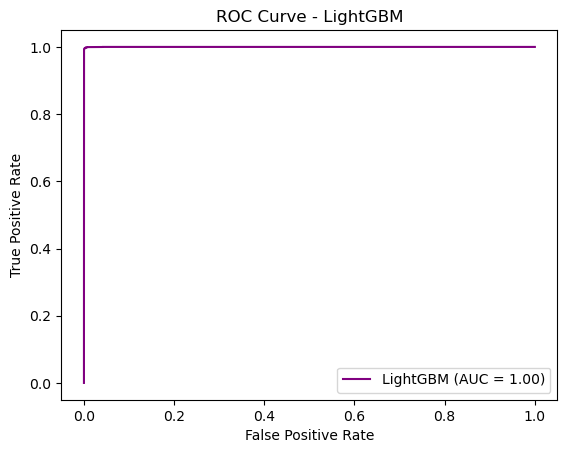

In [66]:
# fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_pred_proba)
# plt.figure()
# plt.plot(fpr_lgb, tpr_lgb, color='purple', label=f'LightGBM (AUC = {roc_auc_lgb:.2f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - LightGBM')
# plt.legend(loc='lower right')
# plt.show()

## CatBoost

In [67]:
# catboost_model = CatBoostClassifier(
#     iterations=100, 
#     learning_rate=0.1, 
#     depth=3,
#     eval_metric='AUC',
#     verbose=10
# )

# catboost_model.fit(X_train, y_train)
# catboost_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

0:	total: 3.85s	remaining: 6m 21s
10:	total: 30.8s	remaining: 4m 9s
20:	total: 55.8s	remaining: 3m 29s
30:	total: 1m 20s	remaining: 2m 59s
40:	total: 1m 45s	remaining: 2m 31s
50:	total: 2m 10s	remaining: 2m 5s
60:	total: 2m 34s	remaining: 1m 38s
70:	total: 2m 58s	remaining: 1m 13s
80:	total: 3m 23s	remaining: 47.6s
90:	total: 3m 47s	remaining: 22.5s
99:	total: 4m 9s	remaining: 0us


In [68]:
# catboost_acc = accuracy_score(y_test, catboost_model.predict(X_test))
# print("Accuracy for CatBoost:", catboost_acc)

# roc_auc_catboost = roc_auc_score(y_test, catboost_pred_proba)
# print("ROC AUC for CatBoost:", roc_auc_catboost)

Accuracy for CatBoost: 0.9838370284529292
ROC AUC for CatBoost: 0.9974600972833232


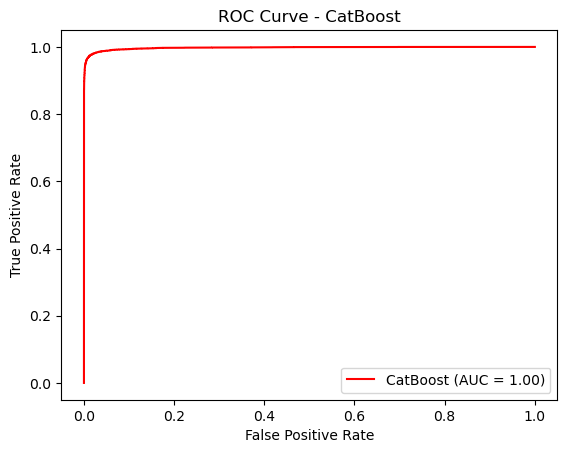

In [69]:
# fpr_catboost, tpr_catboost, _ = roc_curve(y_test, catboost_pred_proba)
# plt.figure()
# plt.plot(fpr_catboost, tpr_catboost, color='red', label=f'CatBoost (AUC = {roc_auc_catboost:.2f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - CatBoost')
# plt.legend(loc='lower right')
# plt.show()

Among the results, the XGBoost wins.

# Submission

In [70]:
y_test.shape, xgb_pred_proba.shape

((32791,), (32791,))

In [81]:
reduced_embeddings = 
reduced_matrix.shape, reduced_embeddings.shape

((3, 1), (141, 1))

In [86]:
test_df = test_essays_df.copy()
test_df = test_df[["id", "text"]]
test_df["text"] = test_df["text"].apply(clean_text)
test_df["tokens"] = test_df["text"].apply(word_tokenize)
test_df["tokens"] = test_df["tokens"].apply(lambda x: [word for word in x if word not in stop_words])

# Apply TF-IDF and Embeddings
test_matrix = vectorizer.transform(test_df["text"])
test_embeddings = np.array([document_vector(word2vec_model, words) for words in test_df["tokens"]])

# # Reduce
# reduced_matrix = matrix_svd.transform(test_matrix)
reduced_embeddings = pca.transform(test_embeddings)
reduced_embeddings = reduced_embeddings

# Conbine
combined_features = hstack([test_matrix, reduced_embeddings])
combined_features

<3x1552681 sparse matrix of type '<class 'numpy.float64'>'
	with 142 stored elements in COOrdinate format>

In [89]:
predictions = xgb_model.predict_proba(combined_features)[:, 1]

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'prediction': predictions
})

submission_df.to_csv('submission.csv', index=False)
submission_df

,id,prediction
0,0000aaaa,0.984820
1,1111bbbb,0.989622
2,2222cccc,0.973095
